In [33]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt
import timeit
import plotly.express as px
import os

pi_unicode = "\u03C0"
times_unicode = "\u00D7"

# Plot HGmodes

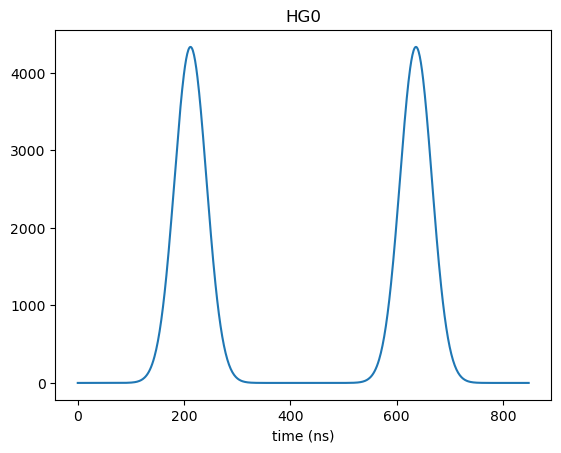

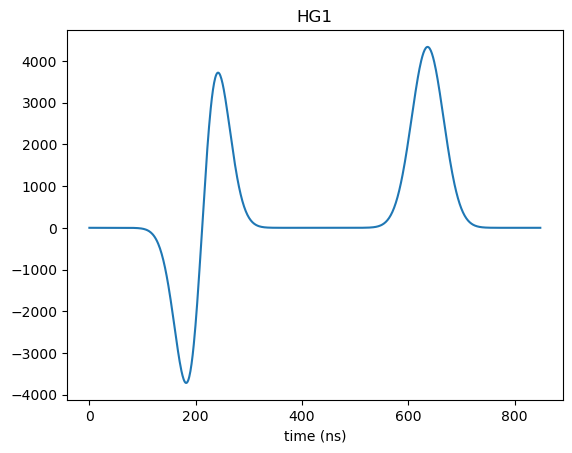

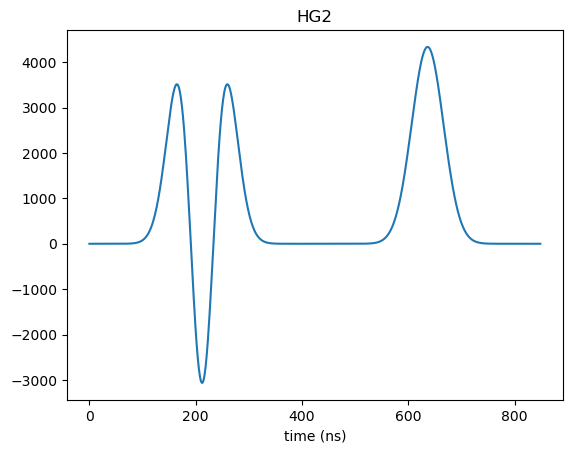

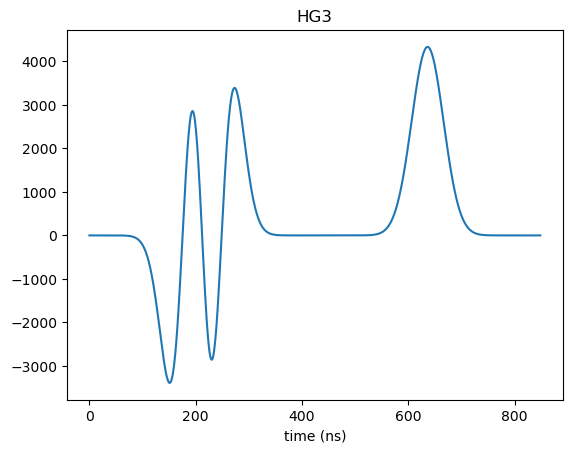

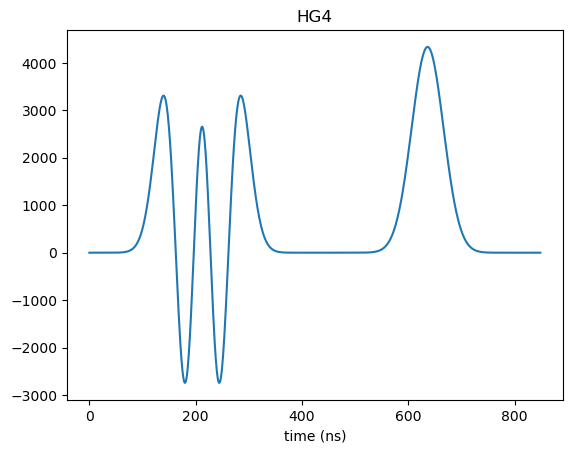

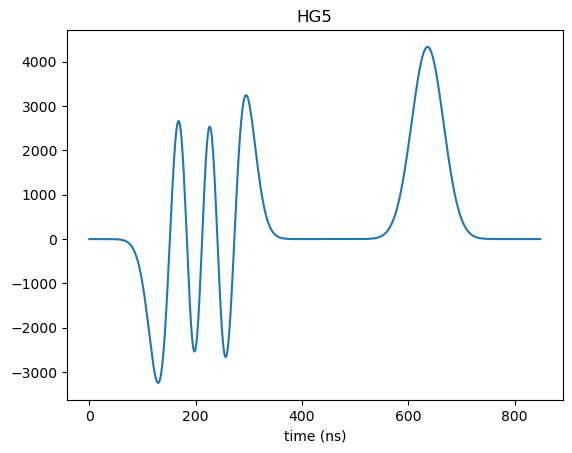

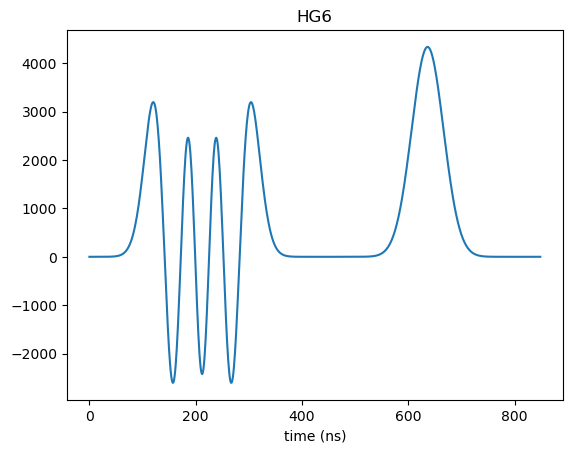

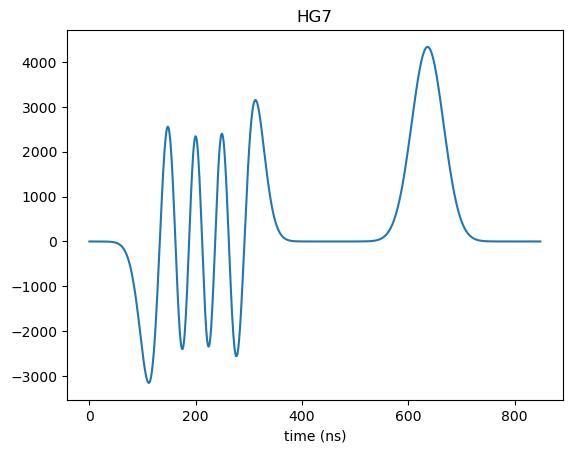

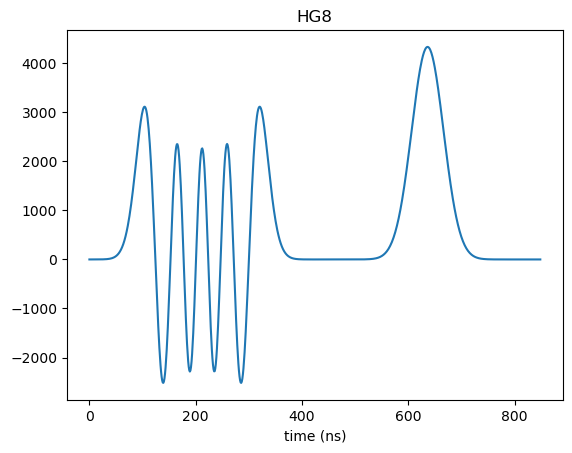

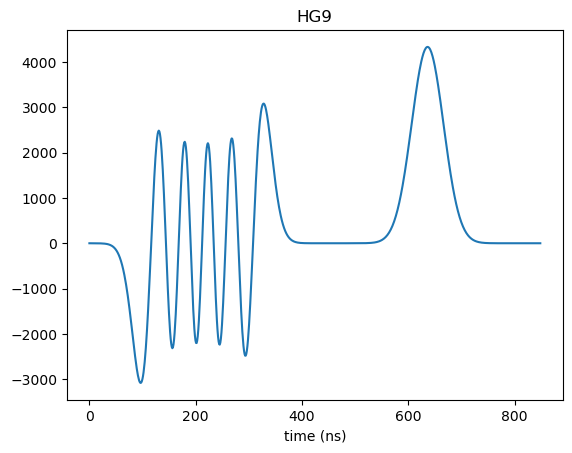

In [12]:
# check fit in simulation window
number_of_modes = 10
tau = np.sqrt(2)*50e-9 # 50ns FWHM in intensity
m = 800

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m)

tr = 2*t0

for signal_mode in range(0, number_of_modes):
    Ein = np.array(S.photon_HermiteG(t, t0, tau, signal_mode))
    Eout = np.array(S.photon_HermiteG(t, t0+tr, tau, 0))
    plt.plot(t*1e9, Ein+Eout)
    plt.title('HG' + str(signal_mode))
    plt.xlabel('time (ns)')
    plt.show()

# Test experimentally measured parameters

Measured around 20% readin.

### Simple 3 level (hot) Raman

In [17]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [18]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  104004
Effective OD =  2299


In [19]:
photon_pol = np.array([1, 0]) #should be normalised

tau = np.sqrt(2)*50e-9 # 50ns FWHM in intensity

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

HGmode = 0
Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

In [20]:
beam_radius = 100e-6 # in m

average_power = 280e-6 # in W
energy_per_sequence = average_power*2e-6 # sequence is 2us long
energy_per_pulse = energy_per_sequence/3 # 3 pulses per sequence

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

Energy per pulse = 186.66666666666663 pJ


In [21]:
tr = 2*t0 # storage time

Control_store = S.photon_HermiteG(t, t0, tau, 0) # temporal shape of control field
Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, 0) # temporal shape of control field

Control_store = atom.set_energy_of_control_pulse(energy_per_pulse, Control_store, t, r=beam_radius)
Control_retrieve = atom.set_energy_of_control_pulse(energy_per_pulse, Control_retrieve, t, r=beam_radius)

print(f"Max rabi frequency of Control_store (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_store))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_store = {atom.control_pulse_to_energy(Control_store, t, r=beam_radius)*1e12: .0f} pJ")
print()

print(f"Max rabi frequency of Control_retrieve (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_retrieve))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_retrieve = {atom.control_pulse_to_energy(Control_retrieve, t, r=beam_radius)*1e12: .0f} pJ")

Max rabi frequency of Control_store (2π × MHz) =  186 
Energy of Control_store =  187 pJ

Max rabi frequency of Control_retrieve (2π × MHz) =  186 
Energy of Control_retrieve =  187 pJ


In [22]:
control_pol = np.array([1, 0]) #should be normalised

Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

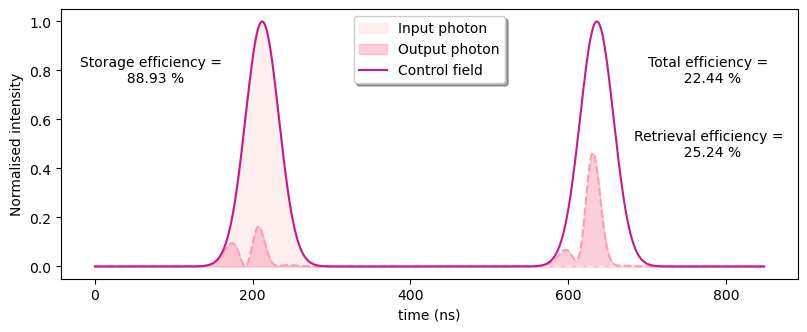

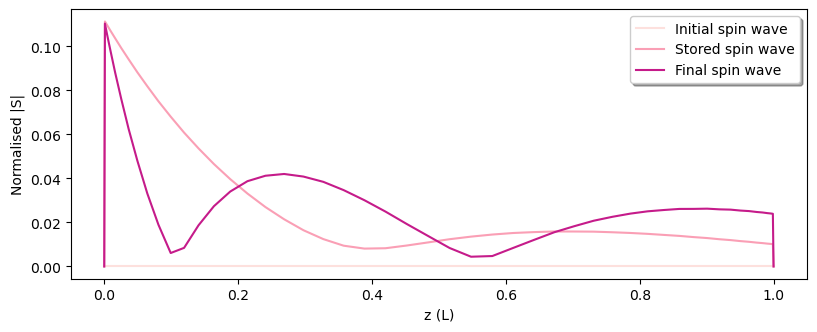

In [23]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.max(np.abs(Control_store)), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text((t0/3)*1e9, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

### Simple 3 level (hot) Raman - fudge factors

In [24]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [25]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 1/6

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  17334
Effective OD =  383


In [26]:
photon_pol = np.array([1, 0]) #should be normalised

tau = np.sqrt(2)*50e-9 # 50ns FWHM in intensity

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

HGmode = 0
Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

In [27]:
beam_radius = 100e-6 # in m

average_power = 280e-6 # in W
energy_per_sequence = average_power*2e-6 # sequence is 2us long
energy_per_pulse = energy_per_sequence/3 # 3 pulses per sequence

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

control_fudge_factor = 1/6

energy_per_pulse = energy_per_pulse * control_fudge_factor

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

Energy per pulse = 186.66666666666663 pJ
Energy per pulse = 31.111111111111104 pJ


In [29]:
tr = 2*t0 # storage time

Control_store = S.photon_HermiteG(t, t0, tau, 0) # temporal shape of control field
Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, 0) # temporal shape of control field

Control_store = atom.set_energy_of_control_pulse(energy_per_pulse, Control_store, t, r=beam_radius)
Control_retrieve = atom.set_energy_of_control_pulse(energy_per_pulse, Control_retrieve, t, r=beam_radius)

print(f"Max rabi frequency of Control_store (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_store))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_store = {atom.control_pulse_to_energy(Control_store, t, r=beam_radius)*1e12: .0f} pJ")
print()

print(f"Max rabi frequency of Control_retrieve (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_retrieve))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_retrieve = {atom.control_pulse_to_energy(Control_retrieve, t, r=beam_radius)*1e12: .0f} pJ")

Max rabi frequency of Control_store (2π × MHz) =  76 
Energy of Control_store =  31 pJ

Max rabi frequency of Control_retrieve (2π × MHz) =  76 
Energy of Control_retrieve =  31 pJ


In [30]:
control_pol = np.array([1, 0]) #should be normalised

Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

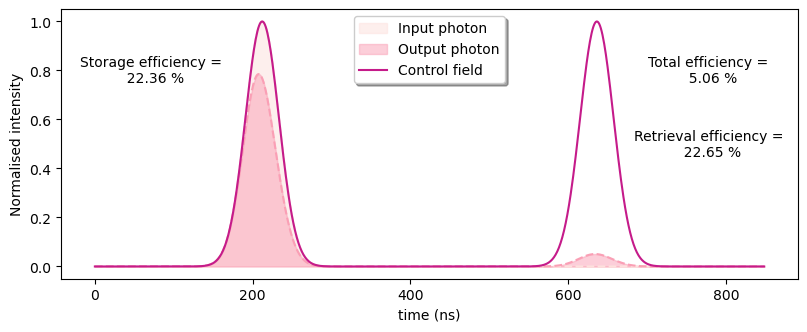

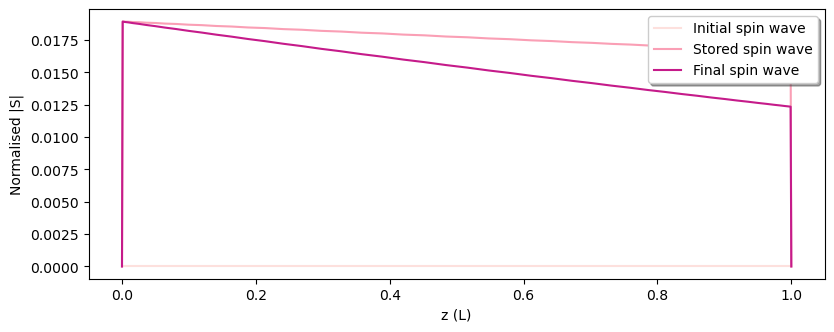

In [31]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.max(np.abs(Control_store)), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text((t0/3)*1e9, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

### Simple 3 level (hot) Raman - test higher mode number

In [32]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [33]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 1/6

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  17334
Effective OD =  383


In [34]:
photon_pol = np.array([1, 0]) #should be normalised

tau = np.sqrt(2)*50e-9 # 50ns FWHM in intensity

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

HGmode = 9
Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

In [35]:
beam_radius = 100e-6 # in m

average_power = 280e-6 # in W
energy_per_sequence = average_power*2e-6 # sequence is 2us long
energy_per_pulse = energy_per_sequence/3 # 3 pulses per sequence

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

control_fudge_factor = 1/6

energy_per_pulse = energy_per_pulse * control_fudge_factor

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

Energy per pulse = 186.66666666666663 pJ
Energy per pulse = 31.111111111111104 pJ


In [39]:
tr = 2*t0 # storage time

Control_store = S.photon_HermiteG(t, t0, tau, HGmode) # temporal shape of control field
Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, 0) # temporal shape of control field

Control_store = atom.set_energy_of_control_pulse(energy_per_pulse, Control_store, t, r=beam_radius)
Control_retrieve = atom.set_energy_of_control_pulse(energy_per_pulse, Control_retrieve, t, r=beam_radius)

print(f"Max rabi frequency of Control_store (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_store))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_store = {atom.control_pulse_to_energy(Control_store, t, r=beam_radius)*1e12: .0f} pJ")
print()

print(f"Max rabi frequency of Control_retrieve (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_retrieve))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_retrieve = {atom.control_pulse_to_energy(Control_retrieve, t, r=beam_radius)*1e12: .0f} pJ")

Max rabi frequency of Control_store (2π × MHz) =  54 
Energy of Control_store =  31 pJ

Max rabi frequency of Control_retrieve (2π × MHz) =  76 
Energy of Control_retrieve =  31 pJ


In [40]:
control_pol = np.array([1, 0]) #should be normalised

Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

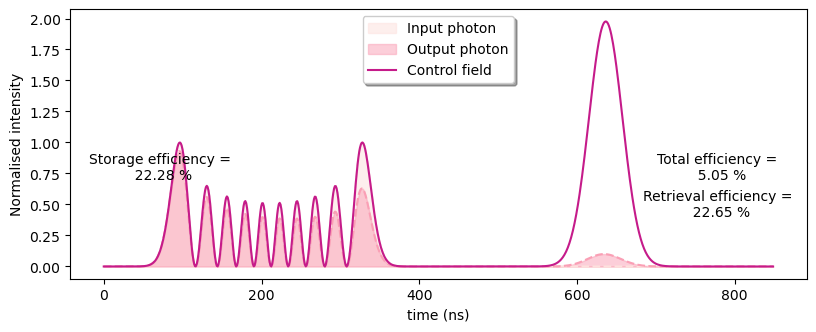

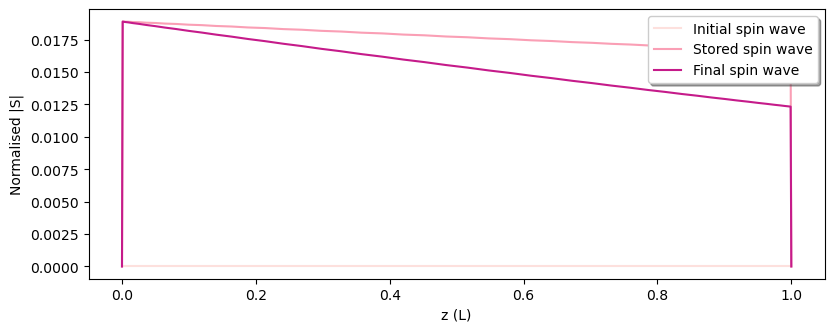

In [41]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.max(np.abs(Control_store)), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text((t0/3)*1e9, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-t0/3)*1e9, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

### Full structure

In [4]:
config = {"Hyperfine splitting": True, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [5]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  104004
Effective OD =  2299


In [6]:
photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised

tau = 50e-9 # 50ns FWHM

t0 = 1.5*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

HGmode = 0
Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

In [8]:
beam_radius = 100e-6 # in m

average_power = 280e-6 # in W
energy_per_sequence = average_power*2e-6 # sequence is 2us long
energy_per_pulse = energy_per_sequence/3 # 3 pulses per sequence

print(f"Energy per pulse = {energy_per_pulse*1e12} pJ")

Energy per pulse = 186.66666666666663 pJ


In [9]:
tr = 120e-9 # storage time

Control_store = S.photon_HermiteG(t, t0, tau, 0) # temporal shape of control field
Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, 0) # temporal shape of control field

Control_store = atom.set_energy_of_control_pulse(energy_per_pulse, Control_store, t, r=beam_radius)
Control_retrieve = atom.set_energy_of_control_pulse(energy_per_pulse, Control_retrieve, t, r=beam_radius)

print(f"Max rabi frequency of Control_store (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_store))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_store = {atom.control_pulse_to_energy(Control_store, t, r=beam_radius)*1e12: .0f} pJ")
print()

print(f"Max rabi frequency of Control_retrieve (2{pi_unicode} {times_unicode} MHz) = {np.max(np.abs(Control_retrieve))/(2*np.pi*1e6): .0f} ")
print(f"Energy of Control_retrieve = {atom.control_pulse_to_energy(Control_retrieve, t, r=beam_radius)*1e12: .0f} pJ")

Max rabi frequency of Control_store (2π × MHz) =  221 
Energy of Control_store =  187 pJ

Max rabi frequency of Control_retrieve (2π × MHz) =  221 
Energy of Control_retrieve =  187 pJ


In [10]:
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised

Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
protocol = 'Raman' # Memory protocol

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

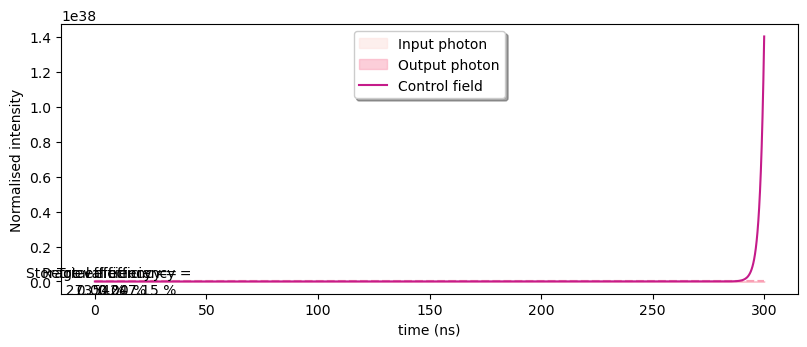

In [11]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2) + pow(np.abs(sol.E[:, 0, 1]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Control_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, (pow(np.abs(sol.E[:, 0, 0]),2) + pow(np.abs(sol.E[:, 0, 1]),2))/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol.E[:, 0, 0])**2 + np.abs(sol.E[:, 0, 1])**2) /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, (pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2))/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, (np.abs(sol.E[:, -1, 0])**2 + np.abs(sol.E[:, -1, 1])**2) /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, (np.abs(Control_tp[:, 0])**2 + np.abs(Control_tp[:, 1])**2)/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.8, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 0.5, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

# Vary HGmode of signal and control

In [42]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [43]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 1/6

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  17334
Effective OD =  383


In [44]:
photon_pol = np.array([1, 0]) #should be normalised

tau = np.sqrt(2)*50e-9 # 50ns FWHM in intensity

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 4*t0 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

HGmode = 0
Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

beam_radius = 100e-6 # in m
tr = 2*t0 # storage time

control_pol = np.array([1, 0]) #should be normalised

In [45]:
number_of_modes = 9
control_energy = 180e-12 # in J
control_fudge_factor = 1/6

control_energy = control_energy * control_fudge_factor

storage_effs = np.zeros((number_of_modes, number_of_modes))
total_effs = np.zeros((number_of_modes, number_of_modes))

for signal_mode in range(0, number_of_modes):
    Einits = np.array(S.photon_HermiteG(t, t0, tau, signal_mode))[:, None] * photon_pol[None, :]
    for control_mode in range(0, number_of_modes):
        Control_store = S.photon_HermiteG(t, t0, tau, control_mode) # temporal shape of control field
        Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, control_mode) # temporal shape of control field

        Control_store = atom.set_energy_of_control_pulse(control_energy, Control_store, t, r=beam_radius)
        Control_retrieve = atom.set_energy_of_control_pulse(control_energy, Control_retrieve, t, r=beam_radius)

        Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
        protocol = 'Raman' # Memory protocol

        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.co_prop( Control_tp )
        sol.solve(Control_tzp, method='RK4-Ralston')

        storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
        retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

        storage_effs[signal_mode, control_mode] = storage
        total_effs[signal_mode, control_mode] = retrieved

In [46]:
fig = px.imshow(storage_effs*100, text_auto = '.2f', x = np.arange(0, number_of_modes), y = np.arange(0, number_of_modes))
fig.update_xaxes(side="top")
fig.update_layout(width = 800,height = 800, font=dict(size=16), yaxis={'tickvals': atom.mq})
fig.show(renderer = 'vscode')

In [47]:
fig = px.imshow(total_effs*100, text_auto = '.2f', x = np.arange(0, number_of_modes), y = np.arange(0, number_of_modes))
fig.update_xaxes(side="top")
fig.update_layout(width = 800,height = 800, font=dict(size=16), yaxis={'tickvals': atom.mq})
fig.show(renderer = 'vscode')

# Vary arrival time of control field

### HG0

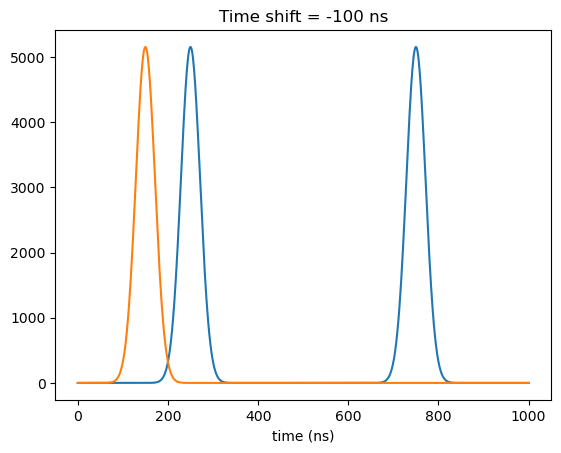

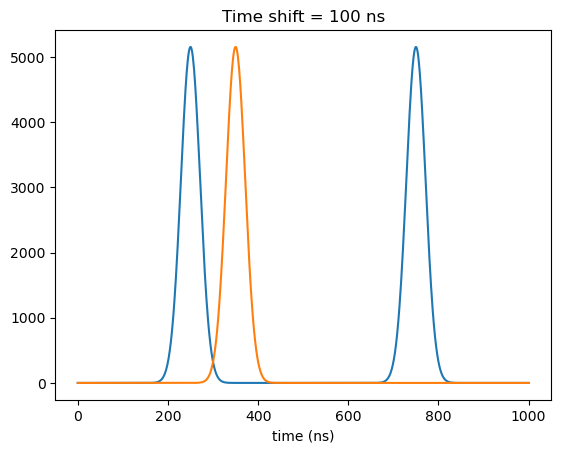

In [71]:
# check fit in simulation window
HGmode = 0
num_of_shifts = 100
t_offset_list = np.linspace(-100, 100, num_of_shifts)*1e-9

tau = 50e-9 # 50ns FWHM in amplitude
m = 800

t0 = 5*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m)

tr = 2*t0

t_offset = t_offset_list[0]
Ein = np.array(S.photon_HermiteG(t, t0, tau, HGmode))
Eout = np.array(S.photon_HermiteG(t, t0+tr, tau, HGmode))
Control = np.array(S.photon_HermiteG(t, t0+t_offset, tau, HGmode))
plt.plot(t*1e9, Ein+Eout)
plt.plot(t*1e9, Control)
plt.title(f'Time shift = {t_offset*1e9:.0f} ns')
plt.xlabel('time (ns)')
plt.show()

t_offset = t_offset_list[-1]
Ein = np.array(S.photon_HermiteG(t, t0, tau, HGmode))
Eout = np.array(S.photon_HermiteG(t, t0+tr, tau, HGmode))
Control = np.array(S.photon_HermiteG(t, t0+t_offset, tau, HGmode))
plt.plot(t*1e9, Ein+Eout)
plt.plot(t*1e9, Control)
plt.title(f'Time shift = {t_offset*1e9:.0f} ns')
plt.xlabel('time (ns)')
plt.show()

In [72]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [73]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 1/6

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  17334
Effective OD =  383


In [74]:
photon_pol = np.array([1, 0]) #should be normalised

Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

beam_radius = 100e-6 # in m
tr = 2*t0 # storage time

control_pol = np.array([1, 0]) #should be normalised

In [75]:
control_energy = 180e-12 # in J
control_fudge_factor = 1/6
control_mode = 0

control_energy = control_energy * control_fudge_factor

storage_effs = np.zeros((num_of_shifts))
total_effs = np.zeros((num_of_shifts))

m_index = np.argmin(np.abs(t-600e-9)) # time step to measure storage


for i in range(0, num_of_shifts):
    t_offset = t_offset_list[i]
    Control_store = S.photon_HermiteG(t, t0+t_offset, tau, HGmode) # temporal shape of control field
    Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, HGmode) # temporal shape of control field

    Control_store = atom.set_energy_of_control_pulse(control_energy, Control_store, t, r=beam_radius)
    Control_retrieve = atom.set_energy_of_control_pulse(control_energy, Control_retrieve, t, r=beam_radius)

    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
    protocol = 'Raman' # Memory protocol

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.co_prop( Control_tp )
    sol.solve(Control_tzp, method='RK4-Ralston')

    storage = sol.storage_efficiency(sol.S, mi=m_index) 
    retrieved = sol.retrieval_efficiency(sol.E, m_index, 0)

    storage_effs[i] = storage
    total_effs[i] = retrieved

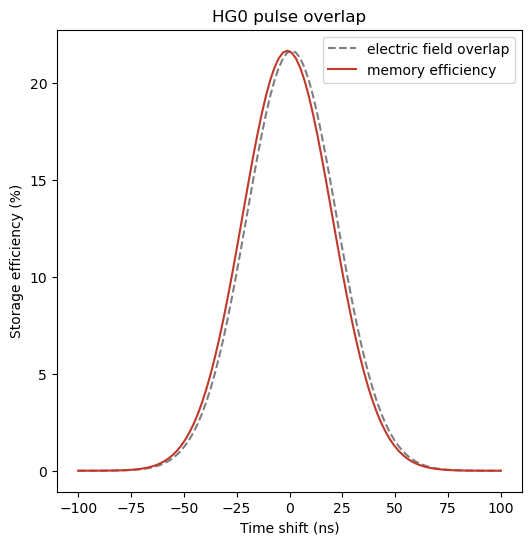

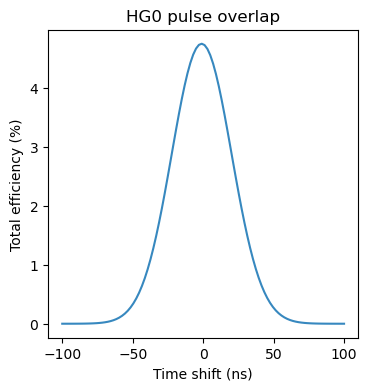

In [76]:
amplitude_overlap = np.abs(np.convolve(S.photon_HermiteG(t_offset_list, 0, tau, HGmode), S.photon_HermiteG(t_offset_list, 0, tau, HGmode), mode='same'))**2
amplitude_overlap = amplitude_overlap/np.max(amplitude_overlap) * np.max(storage_effs)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(t_offset_list*1e9, amplitude_overlap*100, color='k', linestyle='dashed', alpha=0.5, label='electric field overlap')
ax.plot(t_offset_list*1e9, storage_effs*100, color='#c0392bff', label='memory efficiency')
ax.set_ylabel('Storage efficiency (%)', color='k')
ax.set_xlabel('Time shift (ns)')
ax.set_title(f'HG{HGmode} pulse overlap')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(t_offset_list*1e9, total_effs*100, color='#3788bfff')
ax.set_ylabel('Total efficiency (%)', color='k')
ax.set_xlabel('Time shift (ns)')
ax.set_title(f'HG{HGmode} pulse overlap')
plt.show()

In [48]:
# make directory if doesn't exist
directory = 'Temporal_resolution'
os.makedirs(directory, exist_ok=True)

# save data
file = f'{directory}\\HG{HGmode}_time_shift_storage_efficiency.txt'

with open(file,'a') as f:
    np.savetxt(f, np.array([t_offset_list*1e9, storage_effs*100]))

### HG1

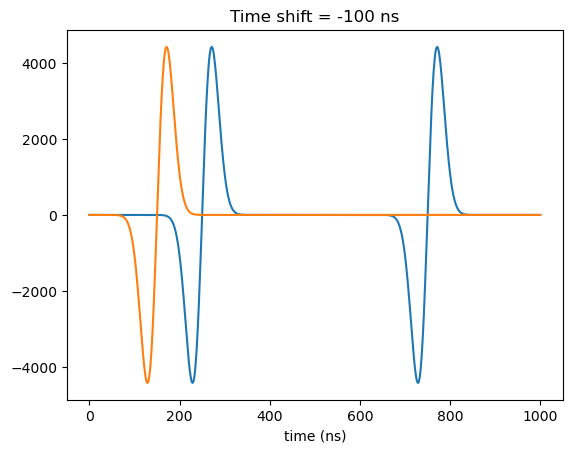

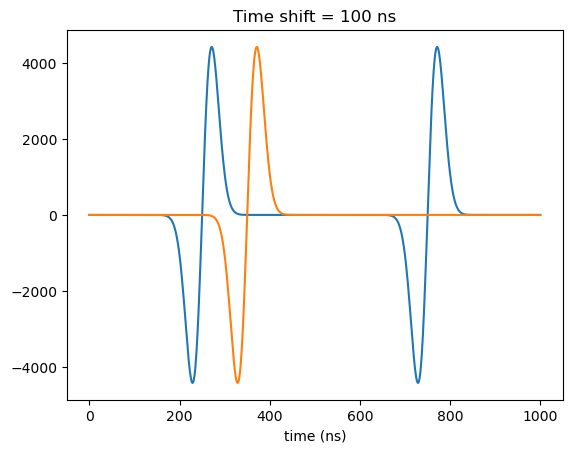

In [49]:
# check fit in simulation window
HGmode = 1
num_of_shifts = 100
t_offset_list = np.linspace(-100, 100, num_of_shifts)*1e-9

tau = 50e-9 # 50ns FWHM in amplitude
m = 800

t0 = 5*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m)

tr = 2*t0

t_offset = t_offset_list[0]
Ein = np.array(S.photon_HermiteG(t, t0, tau, HGmode))
Eout = np.array(S.photon_HermiteG(t, t0+tr, tau, HGmode))
Control = np.array(S.photon_HermiteG(t, t0+t_offset, tau, HGmode))
plt.plot(t*1e9, Ein+Eout)
plt.plot(t*1e9, Control)
plt.title(f'Time shift = {t_offset*1e9:.0f} ns')
plt.xlabel('time (ns)')
plt.show()

t_offset = t_offset_list[-1]
Ein = np.array(S.photon_HermiteG(t, t0, tau, HGmode))
Eout = np.array(S.photon_HermiteG(t, t0+tr, tau, HGmode))
Control = np.array(S.photon_HermiteG(t, t0+t_offset, tau, HGmode))
plt.plot(t*1e9, Ein+Eout)
plt.plot(t*1e9, Control)
plt.title(f'Time shift = {t_offset*1e9:.0f} ns')
plt.xlabel('time (ns)')
plt.show()

In [50]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

In [51]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 1/6

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  17334
Effective OD =  383


In [52]:
photon_pol = np.array([1, 0]) #should be normalised

Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode))[:, None] * photon_pol[None, :] # signal field initial condition

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

beam_radius = 100e-6 # in m
tr = 2*t0 # storage time

control_pol = np.array([1, 0]) #should be normalised

In [53]:
control_energy = 180e-12 # in J
control_fudge_factor = 1/6
control_mode = 0

control_energy = control_energy * control_fudge_factor

storage_effs = np.zeros((num_of_shifts))
total_effs = np.zeros((num_of_shifts))

m_index = np.argmin(np.abs(t-600e-9)) # time step to measure storage

for i in range(0, num_of_shifts):
    t_offset = t_offset_list[i]
    Control_store = S.photon_HermiteG(t, t0+t_offset, tau, HGmode) # temporal shape of control field
    Control_retrieve = S.photon_HermiteG(t, t0+tr, tau, HGmode) # temporal shape of control field

    Control_store = atom.set_energy_of_control_pulse(control_energy, Control_store, t, r=beam_radius)
    Control_retrieve = atom.set_energy_of_control_pulse(control_energy, Control_retrieve, t, r=beam_radius)

    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :] # control field
    protocol = 'Raman' # Memory protocol

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.co_prop( Control_tp )
    sol.solve(Control_tzp, method='RK4-Ralston')

    storage = sol.storage_efficiency(sol.S, mi=m_index) 
    retrieved = sol.retrieval_efficiency(sol.E, m_index, 0)

    storage_effs[i] = storage
    total_effs[i] = retrieved

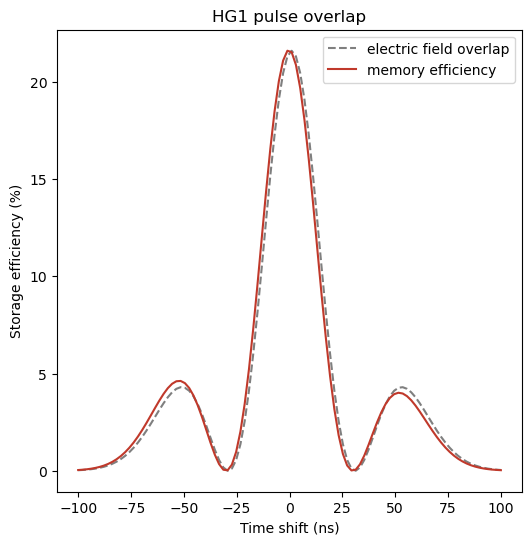

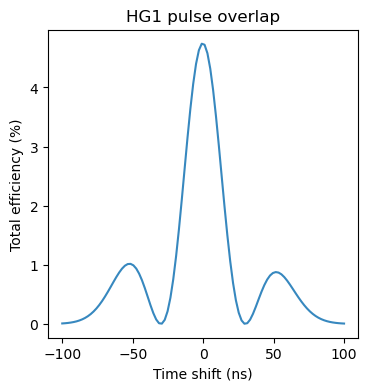

In [70]:
amplitude_overlap = np.abs(np.convolve(S.photon_HermiteG(t_offset_list, 0, tau, HGmode), S.photon_HermiteG(t_offset_list, 0, tau, HGmode), mode='same'))**2
amplitude_overlap = amplitude_overlap/np.max(amplitude_overlap) * np.max(storage_effs)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(t_offset_list*1e9, amplitude_overlap*100, color='k', linestyle='dashed', alpha=0.5, label='electric field overlap')
ax.plot(t_offset_list*1e9, storage_effs*100, color='#c0392bff', label='memory efficiency')
ax.set_ylabel('Storage efficiency (%)', color='k')
ax.set_xlabel('Time shift (ns)')
ax.set_title(f'HG{HGmode} pulse overlap')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(t_offset_list*1e9, total_effs*100, color='#3788bfff')
ax.set_ylabel('Total efficiency (%)', color='k')
ax.set_xlabel('Time shift (ns)')
ax.set_title(f'HG{HGmode} pulse overlap')
plt.show()

In [55]:
# make directory if doesn't exist
directory = 'Temporal_resolution'
os.makedirs(directory, exist_ok=True)

# save data
file = f'{directory}\\HG{HGmode}_time_shift_storage_efficiency.txt'

with open(file,'a') as f:
    np.savetxt(f, np.array([t_offset_list*1e9, storage_effs*100]))